In [62]:
from keras.applications import vgg16, resnet50
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model, Sequential
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Dropout, Reshape, Flatten, Input, concatenate
from keras.utils import np_utils

from PIL import Image
import cv2 as cv
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import string
import re
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
### LOAD DRESS ###
data = pd.read_csv('./FEIDEGGER.csv').fillna(' ')
print(data.shape)
data.head(3)

(43944, 2)


,Image URL,Description
0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"kurze, sexy, sommer, sexy, party, gelb kleid, ..."
1,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,ein gelbes kleid welches eine länge bis etwa ü...
2,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"Knielanges Stoffkleid in gelb mit weitem Rock,..."


In [64]:
### MERGE DESCRIPTION 4 IMAGE URL ###
newdata = data.groupby('Image URL')['Description'].apply(lambda x: x.str.cat(sep=' ')).reset_index()
print(newdata.shape)
newdata.head(3)

(8792, 2)


,Image URL,Description
0,https://i1.ztat.net/large/0V/B2/1C/00/0A/11/0V...,"Ein weißes, knöchellanges Kleid. Es hat einen ..."
1,https://i1.ztat.net/large/0V/B2/1C/00/4G/11/0V...,Ein rotes faltiges Kleid mit mittellangen Ärme...
2,https://i1.ztat.net/large/1V/J2/1C/02/VH/11/1V...,"Ein Schwarzes etwa Knielanges Kleid, mit einem..."


In [65]:
### LOAD VGG ###
vgg_model = vgg16.VGG16(weights='imagenet')
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
### PREPARE IMAGES FOR VGG ###
## A) READ IMAGES AND EXPAND DIM
importedImages = []

for url in tqdm(newdata['Image URL'][0:5]):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    importedImages.append(img_batch.astype('float16'))
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
### EXTRACT FEATURES ###
## B) MAKE PREDICTION
imgs_features = feat_extractor.predict(processed_imgs)
imgs_features.shape

In [66]:
### A + B (DONE AND STORED IN A PICKLE) ###
with open("./img2feat.pkl", 'rb') as pickle_file:
    imgs_features = pickle.load(pickle_file)

print(imgs_features.shape)

(8792, 4096)


In [67]:
### SPLIT TRAIN TEST ###
train = imgs_features[:8000]
print(train.shape)

test = imgs_features[8000:]
print(test.shape)

(8000, 4096)
(792, 4096)


# VISUALIZE DRESS

In [7]:
### REDUCE FEATURE DIMENSIONS ###
pca = PCA(n_components=50)
pca_score = pca.fit_transform(imgs_features)

tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(pca_score)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:04<00:00,  2.02it/s]


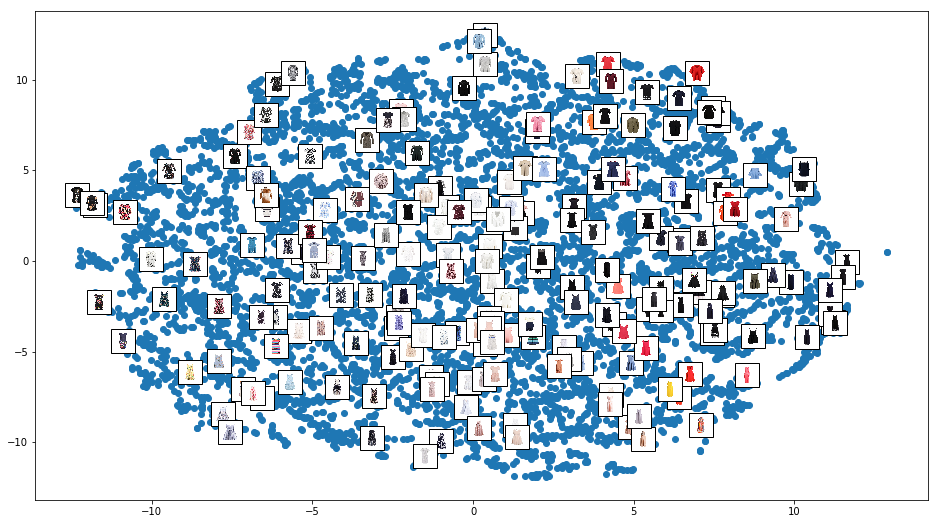

In [12]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(T.T[0], T.T[1]) 
plt.grid(False)

shown_images = np.array([[1., 1.]])
for i in tqdm(np.random.randint(1,T.shape[0],200)):
    
    response = requests.get(newdata['Image URL'][i])
    img = Image.open(BytesIO(response.content))
    img = img.resize((16, 16))
    
    shown_images = np.r_[shown_images, [T[i]]]
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, cmap=plt.cm.gray_r), T[i])
    ax.add_artist(imagebox)

plt.show()

# IMAGES SIMILARITY

In [68]:
### PASS THE TEST ID TO GET THE MOST SIMILAR PRODUCTS ###
def most_similar_products(test_id, n_sim = 3):
    
    #open-plot image
    plt.subplot(1, n_sim+1, 1)
    org_response = requests.get(newdata['Image URL'][train.shape[0]+test_id])
    original = Image.open(BytesIO(org_response.content))
    original = original.resize((224, 224))
    plt.imshow(original)
    plt.title('ORIGINAL')
    
    #compute similarity matrix
    cosSimilarities_serie = cosine_similarity(train, test[test_id].reshape(1,-1)).ravel()
    cos_similarities = pd.DataFrame({'sim':cosSimilarities_serie,'id':newdata[:train.shape[0]].index},
                                    index=newdata['Image URL'][:train.shape[0]]).sort_values('sim',ascending=False)[0:n_sim+1]

    #plot n most similar
    for i in range(0,n_sim):
        
        plt.subplot(1, n_sim+1, i+1+1)
        org_response = requests.get(cos_similarities.index[i])
        original = Image.open(BytesIO(org_response.content))
        original = original.resize((224, 224))
        plt.imshow(original)
        plt.title('Similar'+str(i+1)+': '+str(cos_similarities.sim[i].round(3)))

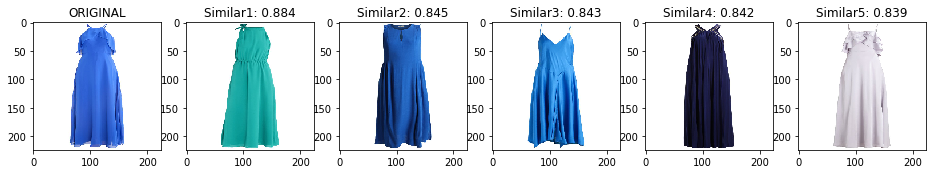

In [69]:
plt.figure(figsize=(16,8))
most_similar_products(7,5)
plt.show()

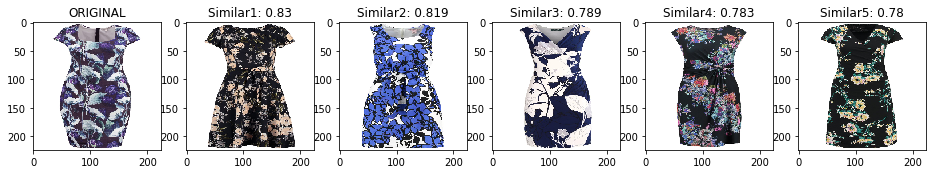

In [70]:
plt.figure(figsize=(16,8))
most_similar_products(28,5)
plt.show()

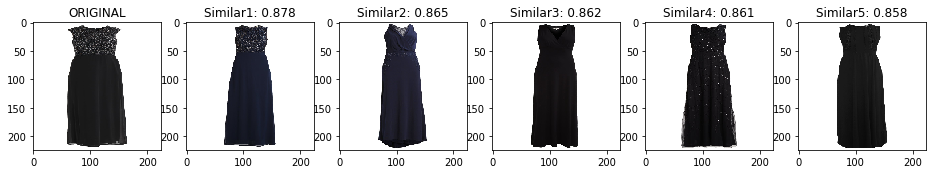

In [71]:
plt.figure(figsize=(16,8))
most_similar_products(9,5)
plt.show()

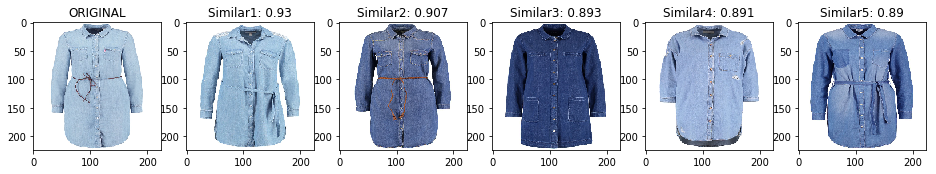

In [159]:
plt.figure(figsize=(16,8))
most_similar_products(10,5)
plt.show()

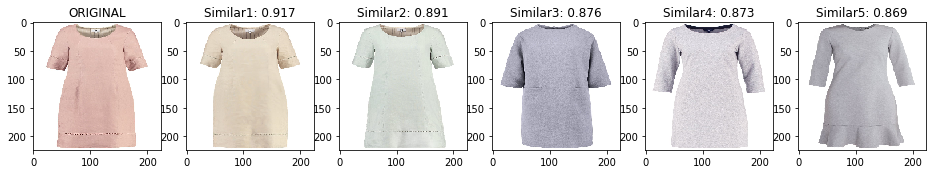

In [72]:
plt.figure(figsize=(16,8))
most_similar_products(347,5)
plt.show()

# TEXT SIMILARITY

In [74]:
del newdata

In [73]:
### CLEAN DESCRIPTION ###
tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-ZäöüßÄÖÜ]+')
nlp = spacy.load('de_core_news_sm')

# keep only noun and adj: return lemma
def clean(txt):

    text = tokenizer.tokenize(txt)
    text = nlp(" ".join(text))
    adj, noun = [], []
    for token in text:
        if token.pos_ == 'ADJ' and len(token)>2:
            adj.append(token.lemma_)
        elif token.pos_ in ['NOUN','PROPN'] and len(token)>2: 
            noun.append(token.lemma_)
            
    return " ".join(adj).lower(), " ".join(noun).lower()

adj, noun = zip(*map(clean,tqdm(data['Description'])))
data['adj_Description'] = list(adj)
data['noun_Description'] = list(noun)

100%|████████████████████████████████████████████████████████████████████████████| 43944/43944 [08:57<00:00, 81.70it/s]


In [75]:
### MERGE CLEAN DESCRIPTION 4 IMAGE URL ###
newdata = data.groupby('Image URL')['adj_Description'].apply(lambda x: x.str.cat(sep=' XXX ')).reset_index()
newdata['noun_Description'] = data.groupby('Image URL')['noun_Description'].apply(lambda x: x.str.cat(sep=' XXX ')).values
print(newdata.shape)
newdata.head(3)

(8792, 3)


,Image URL,adj_Description,noun_Description
0,https://i1.ztat.net/large/0V/B2/1C/00/0A/11/0V...,weiß knöchellanges puffige breit weiß faltig X...,kleid rundausschnitt ärmel taillenbereich quer...
1,https://i1.ztat.net/large/0V/B2/1C/00/4G/11/0V...,rot faltig mittellangen schulterfrei XXX orang...,kleid ärmel knie XXX knielanges stoffkleid fal...
2,https://i1.ztat.net/large/1V/J2/1C/02/VH/11/1V...,schwarze halbrundem XXX knielanges schwarz run...,schwarzes knielanges kleid schnalle gürtel bau...


In [76]:
### DEFINE UTILITY FUNCTION TO OPERATE WITH TEXT ###
remove_adj = ['rund','lang','kurz','kurze','klein','knien','langen','weit']
remove_noun = ['kleid','ärmel','ausschnitt','rock','knie','knielanges','halsen','seite',
               'träge','träger','arm','brust','fuß','schulter','taille','oberteil']

# extract most important words with tfidf
# complete empty space with 'xxx'
def tagging(comments, remove=None, n_word=3):
    
    comments = comments.split('XXX')
    try:
        counter = TfidfVectorizer(min_df=2, analyzer='word', stop_words=remove)
        counter.fit(comments)
        score = counter.transform(comments).toarray().sum(axis=0)
        word = counter.get_feature_names()
        vocab = pd.DataFrame({'w':word,'s':score}).sort_values('s').tail(n_word)['w'].values
        return  " ".join(list(vocab)+['xxx']*(n_word-len(vocab)))
    except:
        return  " ".join(['xxx']*n_word)

In [77]:
### GENERATE LABELS: EXTRACT MOST IMPORTANT WORD ###
tag_noun = newdata['noun_Description'][:train.shape[0]].progress_apply(lambda x: tagging(x,remove_noun))
tag_adj = newdata['adj_Description'][:train.shape[0]].progress_apply(lambda x: tagging(x,remove_adj))
label_noun = np.asarray(tag_noun.str.cat(sep=' ').split(' '))
label_adj = np.asarray(tag_adj.str.cat(sep=' ').split(' '))

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:22<00:00, 347.92it/s]


In [78]:
### GENERATE TRAIN FEATURES: REPLICATE FEATURES WITH THE SAME ORDER OF LABELS ###
features = np.repeat(train, 3, axis=0)

print(features.shape)

(24000, 4096)


In [79]:
### ENCODE LABELS FOR NN ###
y_noun = np_utils.to_categorical(pd.Series(label_noun[label_noun!='xxx']).factorize()[0])
y_adj = np_utils.to_categorical(pd.Series(label_adj[label_adj!='xxx']).factorize()[0])
print(y_noun.shape)
print(y_adj.shape)

(7161, 443)
(15394, 330)


In [80]:
inp_adj = Input(shape=(4096, ))
dense_adj1 = Dense(256, activation='relu')(inp_adj)
dense_adj2 = Dense(128, activation='relu')(dense_adj1)
drop_adj = Dropout(0.5)(dense_adj2)
dense_adj3 = Dense(64, activation='relu')(drop_adj)
out_adj = Dense(y_adj.shape[1], activation='softmax')(dense_adj3)

model_adj = Model(inputs=inp_adj, outputs=out_adj)
model_adj.compile(optimizer='adam', loss='categorical_crossentropy')

inp_noun = Input(shape=(4096, ))
dense_noun1 = Dense(256, activation='relu')(inp_noun)
dense_noun2 = Dense(128, activation='relu')(dense_noun1)
drop_noun = Dropout(0.5)(dense_noun2)
dense_noun3 = Dense(64, activation='relu')(drop_noun)
out_noun = Dense(y_noun.shape[1], activation='softmax')(dense_noun3)

model_noun = Model(inputs=inp_noun, outputs=out_noun)
model_noun.compile(optimizer='adam', loss='categorical_crossentropy')

In [81]:
model_adj.fit(features[label_adj!='xxx'],y_adj,epochs=10,batch_size=512,verbose=2)
model_noun.fit(features[label_noun!='xxx'],y_noun,epochs=10,batch_size=512,verbose=2)

Epoch 1/10
 - 2s - loss: 4.3277
Epoch 2/10
 - 2s - loss: 3.3982
Epoch 3/10
 - 2s - loss: 3.2593
Epoch 4/10
 - 2s - loss: 3.1810
Epoch 5/10
 - 2s - loss: 3.1105
Epoch 6/10
 - 2s - loss: 3.0641
Epoch 7/10
 - 2s - loss: 3.0120
Epoch 8/10
 - 2s - loss: 2.9651
Epoch 9/10
 - 2s - loss: 2.9315
Epoch 10/10
 - 2s - loss: 2.8988
Epoch 1/10
 - 1s - loss: 5.4359
Epoch 2/10
 - 1s - loss: 4.5516
Epoch 3/10
 - 1s - loss: 4.2467
Epoch 4/10
 - 1s - loss: 4.0957
Epoch 5/10
 - 1s - loss: 3.9758
Epoch 6/10
 - 1s - loss: 3.8882
Epoch 7/10
 - 1s - loss: 3.8133
Epoch 8/10
 - 1s - loss: 3.7478
Epoch 9/10
 - 1s - loss: 3.6693
Epoch 10/10
 - 1s - loss: 3.6086


In [82]:
def tag_products(test_id):
    
    # open-plot image
    org_response = requests.get(newdata['Image URL'][train.shape[0]+test_id])
    original = Image.open(BytesIO(org_response.content))
    original = original.resize((224, 224))
    plt.imshow(original)
    plt.title('ORIGINAL')
    plt.show()
    
    #pred noun
    pred_noun = model_noun.predict(test[test_id].reshape(1,-1))
    pred_noun_class = np.argsort(-pred_noun)[0][0:2]
    return_noun_class = pd.Series(label_noun[label_noun!='xxx']).factorize()[1][pred_noun_class].tolist()

    #pred adj
    pred_adj = model_adj.predict(test[test_id].reshape(1,-1))
    pred_adj_class = np.argsort(-pred_adj)[0][0:2]
    return_adj_class = pd.Series(label_adj[label_adj!='xxx']).factorize()[1][pred_adj_class].tolist()

    print('NOUN:', return_noun_class,'\n','ADJ:',return_adj_class)

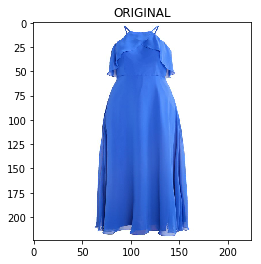

NOUN: ['abendkleid', 'kragen'] 
 ADJ: ['blau', 'schulterfrei']


In [83]:
tag_products(7)

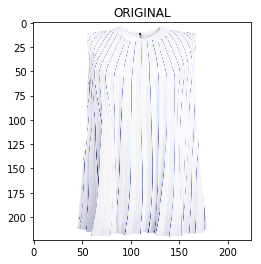

NOUN: ['streife', 'kragen'] 
 ADJ: ['weiß', 'schwarz']


In [84]:
tag_products(8)

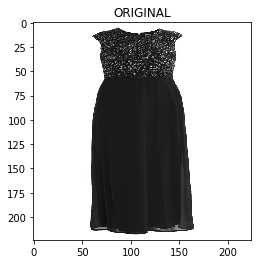

NOUN: ['abendkleid', 'spitzen'] 
 ADJ: ['schwarz', 'ärmellos']


In [85]:
tag_products(9)

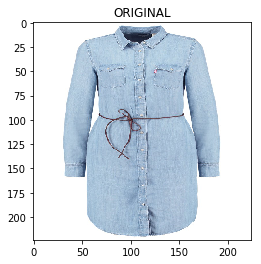

NOUN: ['tasche', 'jeanskleid'] 
 ADJ: ['hellblaues', 'blau']


In [86]:
tag_products(10)

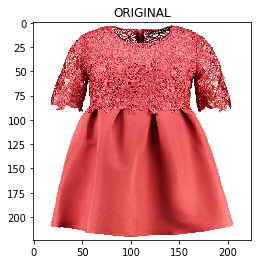

NOUN: ['spitzen', 'mustern'] 
 ADJ: ['rot', 'knielanges']


In [87]:
tag_products(11)

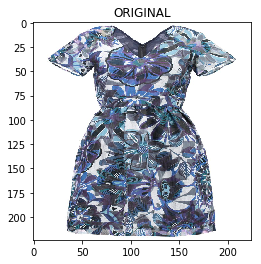

NOUN: ['blumenmuster', 'blume'] 
 ADJ: ['blau', 'weiß']


In [88]:
tag_products(278)

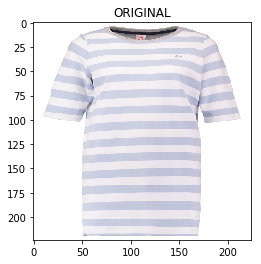

NOUN: ['streife', 'minikleid'] 
 ADJ: ['weiß', 'grau']


In [89]:
tag_products(1)